random으로 타원안에 점찍기

In [ ]:
# import numpy as np
# from matplotlib.patches import Ellipse
# import folium

# # 타원의 속성 설정
# std_point = (33.37283976160554, 126.4439861097205 )
# ellipse = Ellipse((126.545633, 33.377538), width=0.75, height=0.28, angle=13)
# randAns=[]
# count = 0
# while True:
# # 랜덤 좌표 생성
#     num_points = 26 # 생성할 랜덤 점의 개수
#     x_center, y_center = ellipse.center  # 타원 중심 좌표
#     width = ellipse.width / 2  # 타원의 가로 반지름
#     height = ellipse.height / 2  # 타원의 세로 반지름
#     angle = np.deg2rad(ellipse.angle)  # 타원의 기울기 각도

#     # 타원 내의 랜덤 점 생성
#     random_points = []
#     while len(random_points) < num_points:
#         x = np.random.uniform(x_center - width, x_center + width)
#         y = np.random.uniform(y_center - height, y_center + height)
#         if ((x - x_center) / width) ** 2 + ((y - y_center) / height) ** 2 <= 1:
#             x_rot = np.cos(angle) * (x - x_center) - np.sin(angle) * (y - y_center) + x_center
#             y_rot = np.sin(angle) * (x - x_center) + np.cos(angle) * (y - y_center) + y_center
#             random_points.append((x_rot, y_rot))
#     print(random_points)
#     map_osm = folium.Map(location=std_point, zoom_start=10) 

#     for j in random_points:
#         location = (j[1], j[0]) # 위도, 경도 튜플
#         folium.Circle(
#             location=location,
#             radius=1000, 
#             color='blue',
#             weight=1,
#             fill_opacity=0.6,
#             opacity=1,
#             fill_color='black',
#             fill=True,  # gets overridden by fill_color
            
#         ).add_to(map_osm)
#     ans = input()
#     if ans == 't':
#         count +=1
#         randAns.append(random_points)

#     if count >=10:
#         break
#     print(count)
#     map_osm.save('map.html')

# import pickle

# for point in randAns:
#     print(point)
# with open('random_point.pkl', 'wb') as f:
#     pickle.dump(randAns, f)

제주도 타원 근사 시각화(랜덤1000개점)

In [ ]:
# import numpy as np
# from matplotlib.patches import Ellipse
# import folium

# # 타원의 속성 설정
# std_point = (33.37283976160554, 126.4439861097205)
# ellipse = Ellipse((126.545633, 33.377538), width=0.75, height=0.28, angle=13)
# randAns = []

# # 랜덤 좌표 생성
# num_points = 1000  # 생성할 랜덤 점의 개수
# x_center, y_center = ellipse.center  # 타원 중심 좌표
# width = ellipse.width / 2  # 타원의 가로 반지름
# height = ellipse.height / 2  # 타원의 세로 반지름
# angle = np.deg2rad(ellipse.angle)  # 타원의 기울기 각도

# # 타원 내의 랜덤 점 생성
# random_points = []
# while len(random_points) < num_points:
#     x = np.random.uniform(x_center - width, x_center + width)
#     y = np.random.uniform(y_center - height, y_center + height)
#     if ((x - x_center) / width) ** 2 + ((y - y_center) / height) ** 2 <= 1:
#         x_rot = np.cos(angle) * (x - x_center) - np.sin(angle) * (y - y_center) + x_center
#         y_rot = np.sin(angle) * (x - x_center) + np.cos(angle) * (y - y_center) + y_center
#         random_points.append((x_rot, y_rot))
# print(random_points)

# map_osm = folium.Map(location=std_point, zoom_start=10)

# for j in random_points:
#     location = (j[1], j[0])  # 위도, 경도 튜플
#     folium.Circle(
#         location=location,
#         radius=1000,
#         color='blue',
#         weight=1,
#         fill_opacity=0.6,
#         opacity=1,
#         fill_color='black',
#         fill=True,  # gets overridden by fill_color
#     ).add_to(map_osm)

# map_osm.save('map 1000.html')
# map_osm

네트워크 기본 세팅

In [1]:
import pandas as pd
import networkx as nx
from haversine import haversine
import matplotlib.pyplot as plt
import math
import pickle

%matplotlib inline

def serviceArea(graph, nodelist = [], w =5):
    ret = {}
    for node in nodelist:
        shortest_paths = nx.single_source_dijkstra_path_length(graph, node, cutoff=w, weight='weight')
        tmp=ret
        for key in set(shortest_paths.keys()).intersection(ret.keys()):
            tmp[key] = min(shortest_paths[key], ret[key])
        tmp.update({key: shortest_paths[key] for key in set(shortest_paths.keys()) - set(ret.keys())})
        tmp.update({key: ret[key] for key in set(ret.keys()) - set(shortest_paths.keys())})
        ret = tmp
    return ret

def connectRes(graph, df): # df는 idx, latitude, longitude가 있어야함
    nodes_latitude = nx.get_node_attributes(graph, 'latitude')
    nodes_longitude = nx.get_node_attributes(graph, 'longitude')
    for idx, row in df.iterrows():
        distances ={}
        for keyLong, valLat in nodes_latitude.items():
            nodesPos = (valLat, nodes_longitude[keyLong])
            curPos = (row['latitude'], row['longitude'])
            distances[keyLong] = haversine(nodesPos, curPos, unit='km')
        nearest_node = min(distances, key=distances.get)
        graph.add_node(idx, Label=idx, latitude=row['latitude'], longitude=row['longitude']) ##노드이름은 4050000000이하로 설정
        w = distances[nearest_node]*1000/666 #단위 변환 km->m(*1000), 거리(m)->시간(분) (40km/h = 666m/s)
        graph.add_edge(nearest_node, idx, weight=w)
    return graph

def adjust_distance(distance):
    ret = math.ceil(distance)
    return ret

nodes = pd.read_csv('data/Jeju_nodes.csv', encoding='utf-8')
links = pd.read_csv('data/Jeju_links.csv', encoding='cp949')
car = pd.read_csv('data/Jeju_car.csv', encoding='cp949')
with open('random_point.pkl', 'rb') as f:
    randomPoints = pickle.load(f)
    
nodes = nodes[['Id','NODE_NAME','latitude','longitude', 'average population']]
links = links[['Source','Target', '시간']]
source_in = links['Source'].apply(lambda x : x in list(nodes['Id'])) # check Sources are in jeju
target_in = links['Target'].apply(lambda x : x in list(nodes['Id'])) # check Targets are in jeju
# source_in and target_in are boolean type pandas.Series which contains True or False
jeju_links = links[source_in & target_in] # contain if both target and source are contained in jeju

print(f"Number of Nodes: {len(nodes)}")
print(f"Number of Links: {len(jeju_links)}")

Number of Nodes: 4218
Number of Links: 12068


-------------------------------------------------------------------------------------------------------------------------------------------------

거리별(정수) 노드수 그래프

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] 23
[26.0, 33.1, 95.5, 152.6, 230.8, 318.1, 351.2, 374.6, 378.4, 347.7, 345.7, 300.6, 279.1, 239.8, 210.7, 179.8, 126.6, 92.9, 61.8, 37.6, 28.9, 17.2, 6.9] 23
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21],
      dtype='int64', name='Adjusted_Distance')
[ 26 213 669 685 521 470 426 317 236 175 158 119  82  57  20  20  19  14
   6   3   1   3]


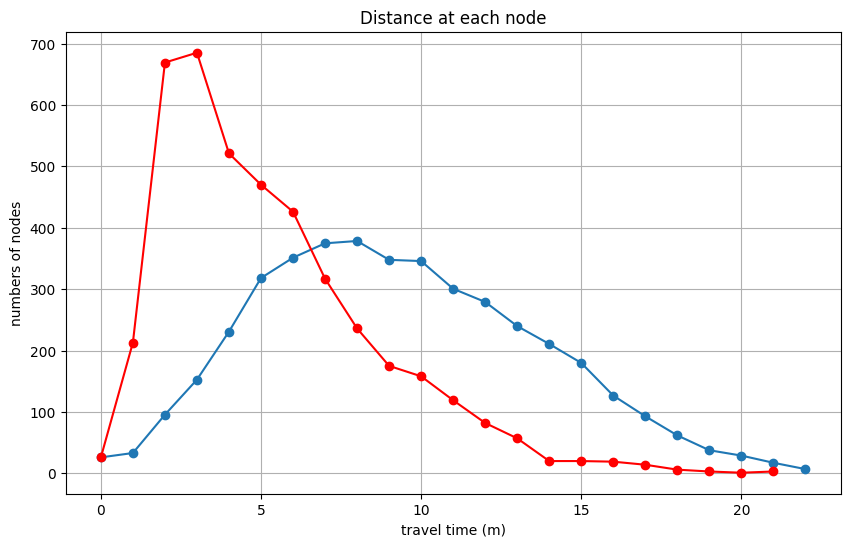

In [96]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 22)
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
result_df['Adjusted_Distance'] = result_df['Distance'].apply(adjust_distance)
node_counts = result_df.groupby('Adjusted_Distance').size()

# 여기는 랜덤판
result_x = []
result_y = []
for pointsList in randomPoints:
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 22)
    result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    result_df['Adjusted_Distance'] = result_df['Distance'].apply(adjust_distance)
    Rand_node_counts = result_df.groupby('Adjusted_Distance').size()
    x = list(Rand_node_counts.index)
    if len(x) > len(result_x):
        result_x = x
    y = list(Rand_node_counts.values)
    if result_y == []:
        result_y = y
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
result_y = [y/10 for y in result_y]
print(result_x, len(result_x))
print(result_y, len(result_y))
# make graph
plt.figure(figsize=(10, 6))
plt.plot(result_x, result_y, marker='o')
print(node_counts.index)
print(node_counts.values)
plt.plot(node_counts.index, node_counts.values, marker='o', color = 'red')
plt.title('Distance at each node')
plt.xlabel('travel time (m)')
plt.ylabel('numbers of nodes')
plt.grid(True)
plt.show()

G.nodes들 중에서 랜덤으로 뽑기

In [10]:
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 22)
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
result_df['Adjusted_Distance'] = result_df['Distance'].apply(adjust_distance)
node_counts = result_df.groupby('Adjusted_Distance').size()
node_counts

Adjusted_Distance
0      26
1     213
2     669
3     685
4     521
5     470
6     426
7     317
8     236
9     175
10    158
11    119
12     82
13     57
14     20
15     20
16     19
17     14
18      6
19      3
20      1
21      3
dtype: int64

In [ ]:
# random_Gnodes=[]
# randG = list(G.nodes(data=True))
# import random
# import pickle

# for _ in range(10):
#     tmp = []
#     for _ in range(26):
#         randNum = random.randint(0, len(randG))
#         tmp.append((randG[randNum][1]['longitude'], randG[randNum][1]['latitude']))
#     random_Gnodes.append(tmp)

# with open('random_nodes.pkl', 'wb') as f:
#     pickle.dump(random_Gnodes, f)

In [ ]:
with open('random_point.pkl', 'rb') as f:
    random_Gnodes = pickle.load(f)
# random_Gnodes

4215 4240
4215 4186
4215 4211
4215 4236
4215 4175
4215 4233
4215 4239
4215 4225
4215 4237
4215 4240


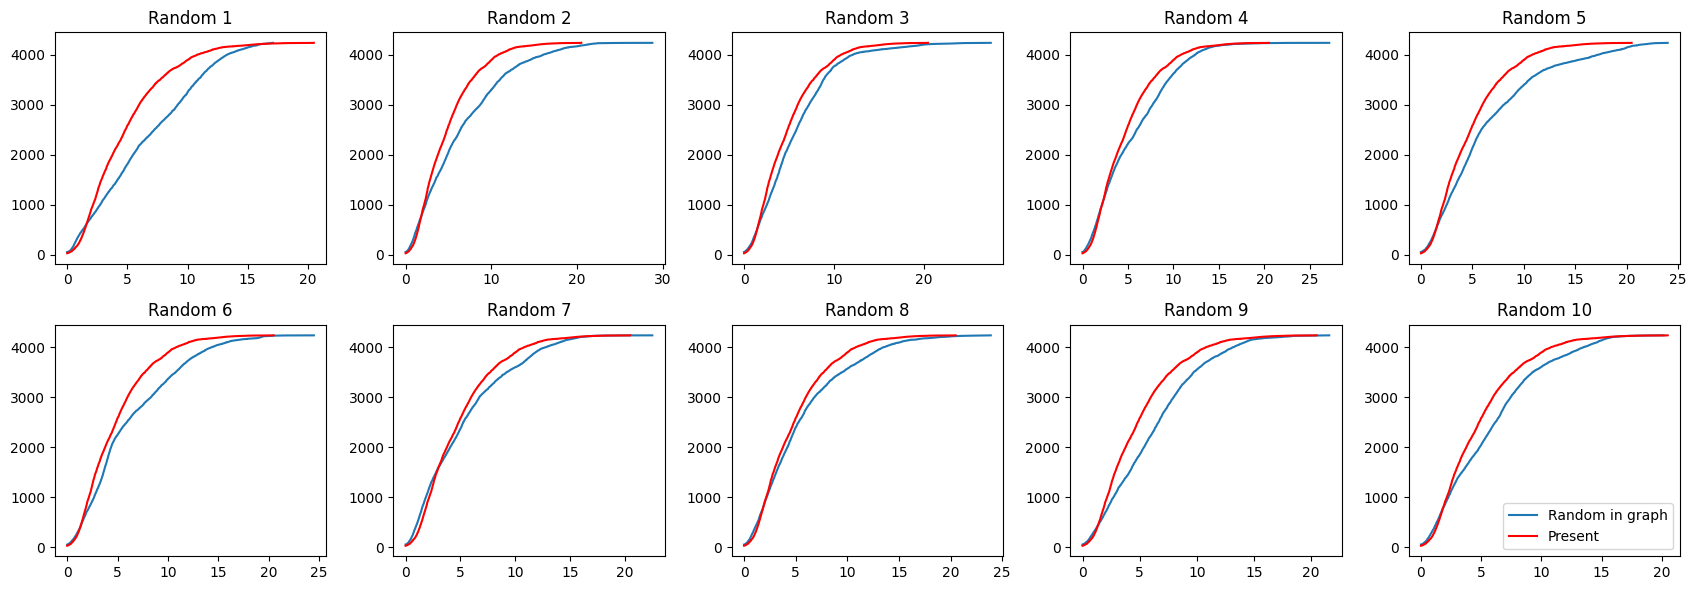

[] 0
[51.7, 53.8, 54.0, 54.1, 54.3, 54.5, 55.4, 55.4, 56.6, 56.7, 56.7, 59.4, 60.3, 62.8, 62.8, 69.3, 69.7, 71.3, 72.2, 74.9, 77.2, 78.8, 78.8, 79.1, 79.2, 82.6, 84.8, 85.5, 86.3, 86.3, 87.3, 88.8, 91.5, 91.5, 98.4, 100.3, 102.0, 106.2, 107.0, 110.5, 111.3, 113.7, 115.0, 116.4, 119.0, 119.2, 119.8, 119.9, 120.1, 122.5, 124.6, 125.5, 125.9, 126.1, 128.1, 128.1, 128.4, 130.6, 131.2, 133.7, 134.2, 134.3, 137.1, 139.2, 139.3, 139.5, 142.6, 146.7, 146.8, 147.6, 148.0, 148.0, 149.4, 151.7, 154.2, 155.0, 160.1, 160.6, 163.7, 164.6, 165.0, 166.8, 168.1, 171.5, 172.6, 181.1, 181.2, 182.5, 182.9, 182.9, 183.0, 183.7, 184.3, 184.6, 185.2, 185.3, 185.9, 187.3, 188.6, 190.4, 192.3, 193.1, 195.8, 195.8, 196.0, 196.4, 196.6, 196.8, 203.3, 203.6, 203.7, 204.6, 205.1, 205.2, 206.8, 208.3, 219.0, 219.4, 221.6, 223.1, 223.4, 224.0, 224.4, 224.8, 225.7, 228.6, 229.0, 231.7, 232.9, 233.1, 234.4, 237.3, 239.4, 240.7, 241.2, 245.9, 248.9, 251.0, 253.1, 253.9, 254.4, 254.8, 257.2, 257.8, 262.6, 263.9, 264.1, 

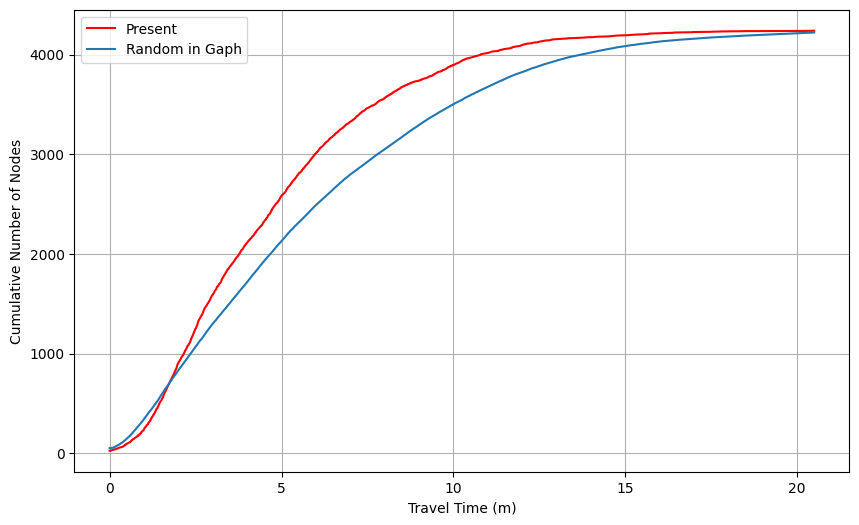

In [60]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 30)
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
distancesReal = sorted(result_df['Distance'].unique())
cumulative_counts = [result_df[result_df['Distance'] <= distance].shape[0] for distance in distancesReal]


# ------- 여기는 랜덤판
result_x = []
result_y = []
iter = 0
fig = plt.figure(figsize=(17, 6)) # subplot drawing
for pointsList in random_Gnodes:
    iter +=1
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 30)
    random_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    distances = sorted(random_df['Distance'].unique())
    random_counts = [random_df[random_df['Distance'] <= distance].shape[0] for distance in distances]
    
    ax = fig.add_subplot(2, 5, iter)
    ax.plot(distances, random_counts, label = 'Random in graph')
    ax.plot(distancesReal, cumulative_counts, label = 'Present', color = 'red')
    ax.set_title(f"Random {iter}")
    
    distances = sorted(result_df['Distance'].unique())
    random_counts = [random_df[random_df['Distance'] <= distance].shape[0] for distance in distances]
    x = distances
    y = random_counts
    print(len(y), y[-1])
    if result_y == []:
        result_y = y    
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
    
plt.tight_layout()
plt.legend()
plt.savefig('result/Random Graph_Cumulative Number of Nodes by Distance.png')
plt.show()

result_y = [y/10 for y in result_y]
print(result_x, len(result_x))
print(result_y, len(result_y))
print(distances, len(cumulative_counts))


# 거리별 노드 개수를 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.plot(distancesReal, cumulative_counts, marker='o', markersize = 0, color = 'red', label = 'Present')
plt.plot(distances, result_y, marker='o', markersize = 0, label = 'Random in Gaph')
plt.legend()

# 그래프 제목과 축 이름 설정
plt.xlabel('Travel Time (m)')
plt.ylabel('Cumulative Number of Nodes')
plt.grid(True)
# 그래프 출력
plt.savefig('result/Graph_Cumulative Number of Nodes by Travel Time.png')
plt.show()

거리별(실수) 노드수(합) 그래프

4215 [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 54, 56, 56, 56, 56

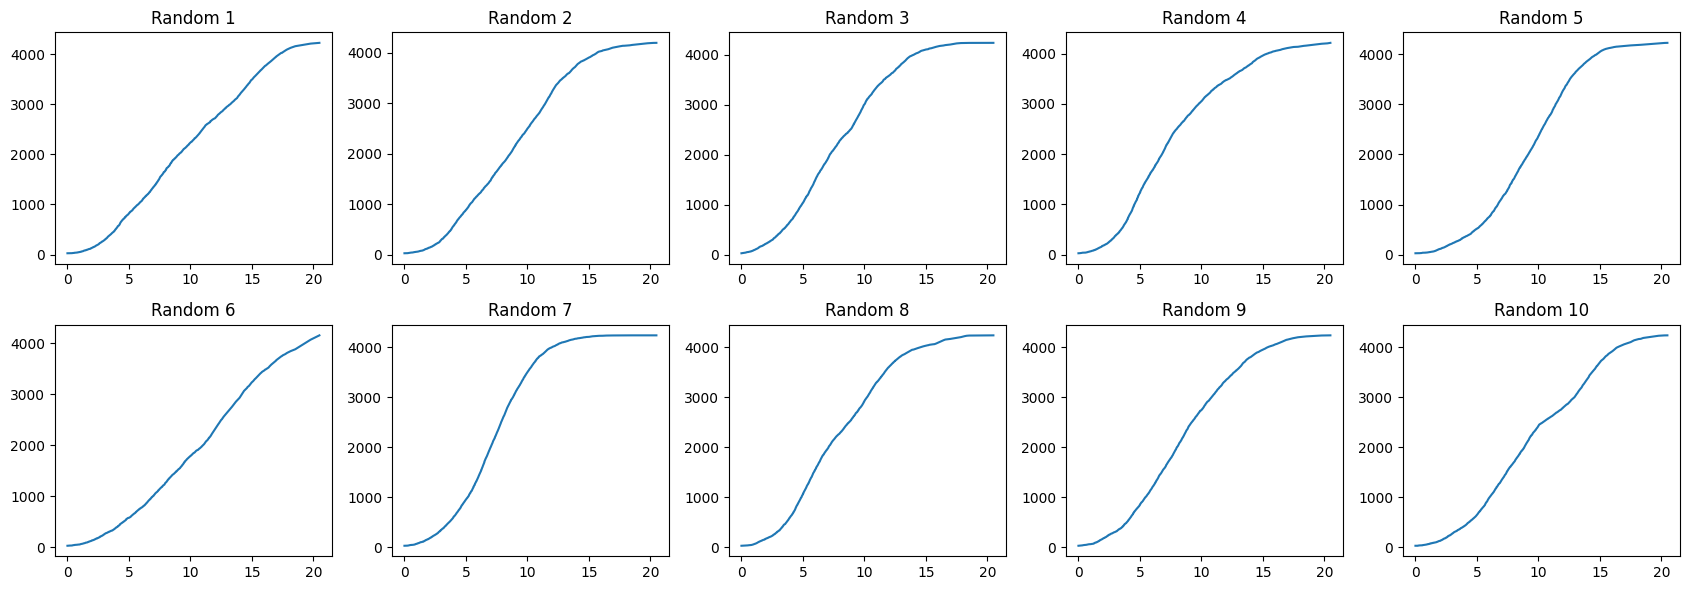

[0.0, 0.05358281992992601, 0.05572713394703723, 0.057675469557528704, 0.06067167871664851, 0.06497805724952183, 0.0843764195791417, 0.0850409937965719, 0.10041258823944851, 0.10401844353202479, 0.10500422382127927, 0.1217300877644879, 0.12746311274287353, 0.1448500458575287, 0.14533125241350542, 0.17531371594703724, 0.17680325517451284, 0.18471438869576437, 0.19213003657914168, 0.2032682401239915, 0.21928272771664853, 0.22606989507451283, 0.22611216447926225, 0.2282083885575287, 0.22883564023944852, 0.24536678024952183, 0.2594943296575287, 0.263683760929926, 0.268115260929926, 0.2685550317644879, 0.2747272818575287, 0.2811750572394485, 0.29442863274287356, 0.2947052355791417, 0.3174195295320248, 0.32751192892992603, 0.33728654707451283, 0.35655229041350545, 0.36063236424952183, 0.37179146755752873, 0.37389319494738227, 0.3868476172394485, 0.3919446628575287, 0.3970326237644879, 0.40670544871664854, 0.4070017696575287, 0.4102363808212793, 0.4107217706575287, 0.4121806737166485, 0.418727

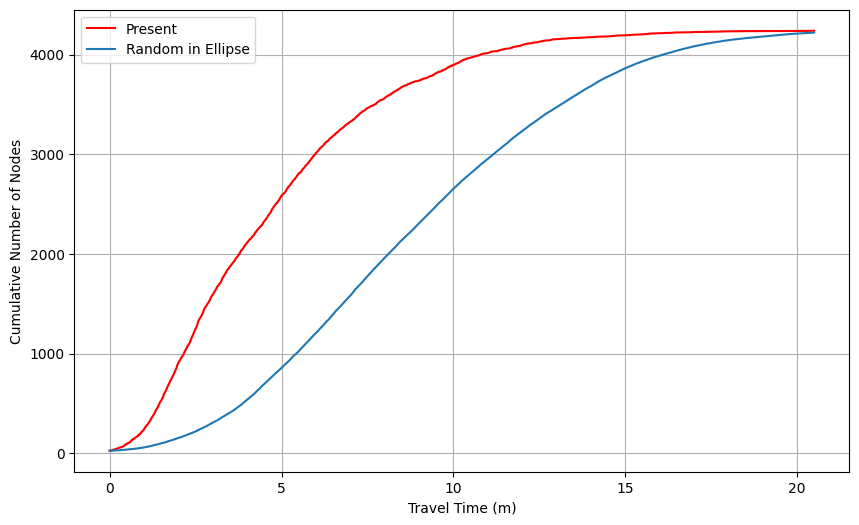

In [46]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 22)
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
distances = sorted(result_df['Distance'].unique())
cumulative_counts = [result_df[result_df['Distance'] <= distance].shape[0] for distance in distances]


# ------- 여기는 랜덤판
result_x = []
result_y = []
iter = 0
fig = plt.figure(figsize=(17, 6)) # subplot drawing
for pointsList in randomPoints:
    iter +=1
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 22)
    random_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    random_counts = [random_df[random_df['Distance'] <= distance].shape[0] for distance in distances]
    
    x = distances
    if len(x) > len(result_x):
        result_x = x
    y = random_counts
    print(len(y), y)
    if result_y == []:
        result_y = y
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
    # subplot
    ax = fig.add_subplot(2, 5, iter)
    ax.plot(x, y)
    ax.set_title(f"Random {iter}")
plt.tight_layout()
plt.savefig('result/Random Ellipse_Cumulative Number of Nodes by Distance.png')
plt.show()

result_y = [y/10 for y in result_y]
print(result_x, len(result_x))
print(result_y, len(result_y))
print(distances, len(cumulative_counts))


distances = sorted(result_df['Distance'].unique())
cumulative_counts = [result_df[result_df['Distance'] <= distance].shape[0] for distance in distances]

# 거리별 노드 개수를 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.plot(distances, cumulative_counts, marker='o', markersize = 0, color = 'red', label = 'Present')
plt.plot(result_x, result_y, marker='o', markersize = 0, label = 'Random in Ellipse')
plt.legend()
# 그래프 제목과 축 이름 설정
plt.xlabel('Travel Time (m)')
plt.ylabel('Cumulative Number of Nodes')
plt.grid(True)
# 그래프 출력
plt.savefig('result/Ellipse_Cumulative Number of Nodes by Travel Time.png')
plt.show()

인구수 고려

4240
4241
4215 4215 623442.4671889998
4240
4214 4214 623387.1027309931
4240
4214 4214 623387.102730992
4240
4214 4214 623387.1027310237
4240
4214 4214 623387.1027310007
4240
4214 4214 623387.1027309931
4240
4214 4214 623387.1027310123
4240
4214 4214 623387.1027309941
4240
4214 4214 623387.1027310035
4240
4214 4214 623387.1027310048


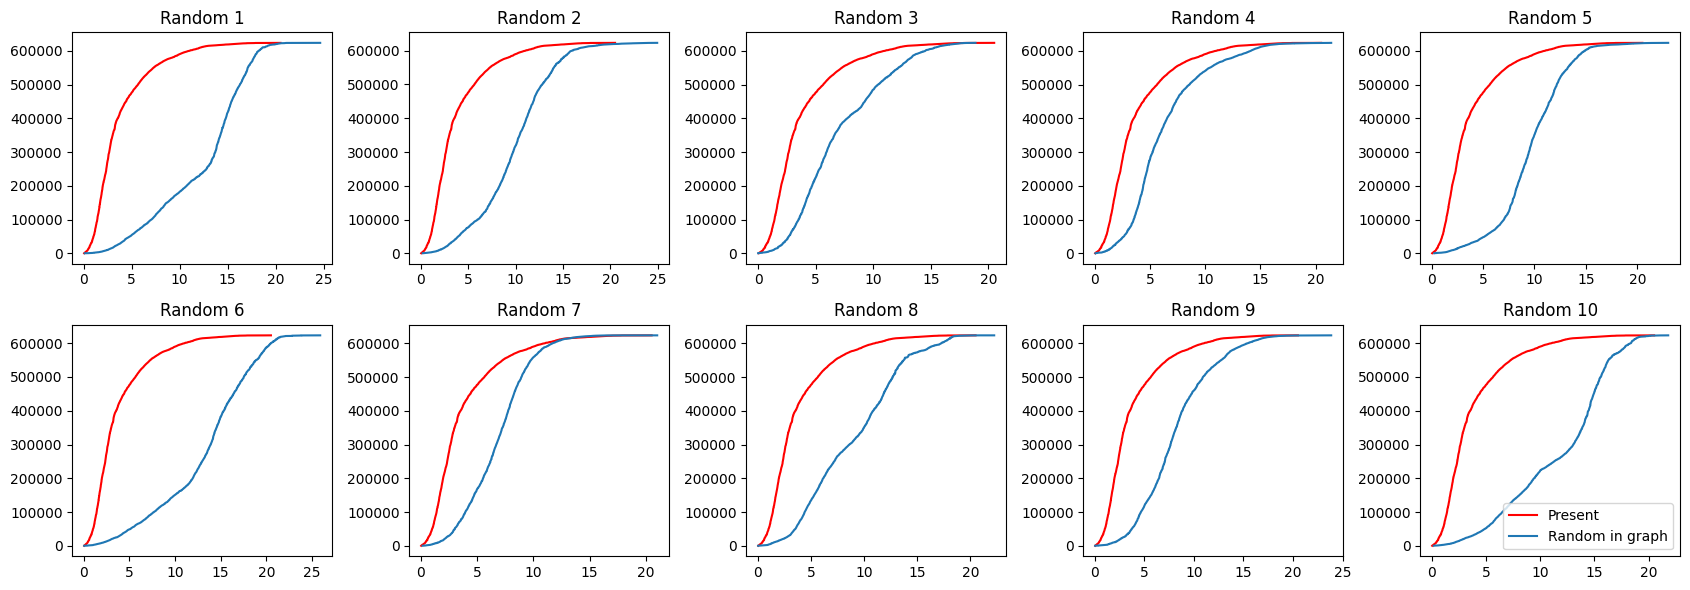

In [65]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 40)
print(len(area))
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
merged_df = pd.merge(result_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
grouped_data = merged_df.groupby('Distance')['average population'].sum()
cumulative_population = grouped_data.cumsum()

# ------- 여기는 랜덤판
result_x = []
result_y = []
iter = 0
fig = plt.figure(figsize=(17, 6)) # subplot drawing
for pointsList in random_Gnodes:
    iter +=1
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 40)
    print(len(area))
    random_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    mergedRandom = pd.merge(random_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
    groupedRandom = mergedRandom.groupby('Distance')['average population'].sum()
    randomPopulation = groupedRandom.cumsum()
    
    x = randomPopulation.index.tolist()
    y = randomPopulation.values.tolist()
    print(len(x),len(y), y[-1])
    
    if result_y == []:
        result_y = y
        result_x = x
    elif len(result_y) < len(y):
        for i in range(len(result_y)):
            result_y[i] = result_y[i] + y[i]
            result_x = x
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
    # subplot
    ax = fig.add_subplot(2, 5, iter)
    ax.plot(cumulative_population.index, cumulative_population.values, color = 'red', label = 'Present')
    ax.plot(x, y, label = 'Random in graph')
    ax.set_title(f"Random {iter}")
plt.tight_layout()
plt.legend()
plt.savefig('result/Random Graph_Cumulative Population by Travel Time.png')
plt.show()

# result_y = [y/10 for y in result_y]

# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_population.index, cumulative_population.values, marker='o', markersize = 0, color = 'red', label ='Present')
# plt.plot(result_x, result_y, marker='o', markersize = 0, label = 'Random in Graph')
# plt.legend()
# plt.xlabel('Travel Time (m)')
# plt.ylabel('Cumulative Population')
# plt.grid(True)
# plt.savefig('result/Graph_Cumulative Population by Travel Time.png')
# plt.show()

타원!

4240
4241
4215 623442.4671889998
4240
4214 623387.1027309931
4240
4214 623387.102730992
4240
4214 623387.1027310237
4240
4214 623387.1027310007
4240
4214 623387.1027309931
4240
4214 623387.1027310123
4240
4214 623387.1027309941
4240
4214 623387.1027310035
4240
4214 623387.1027310048


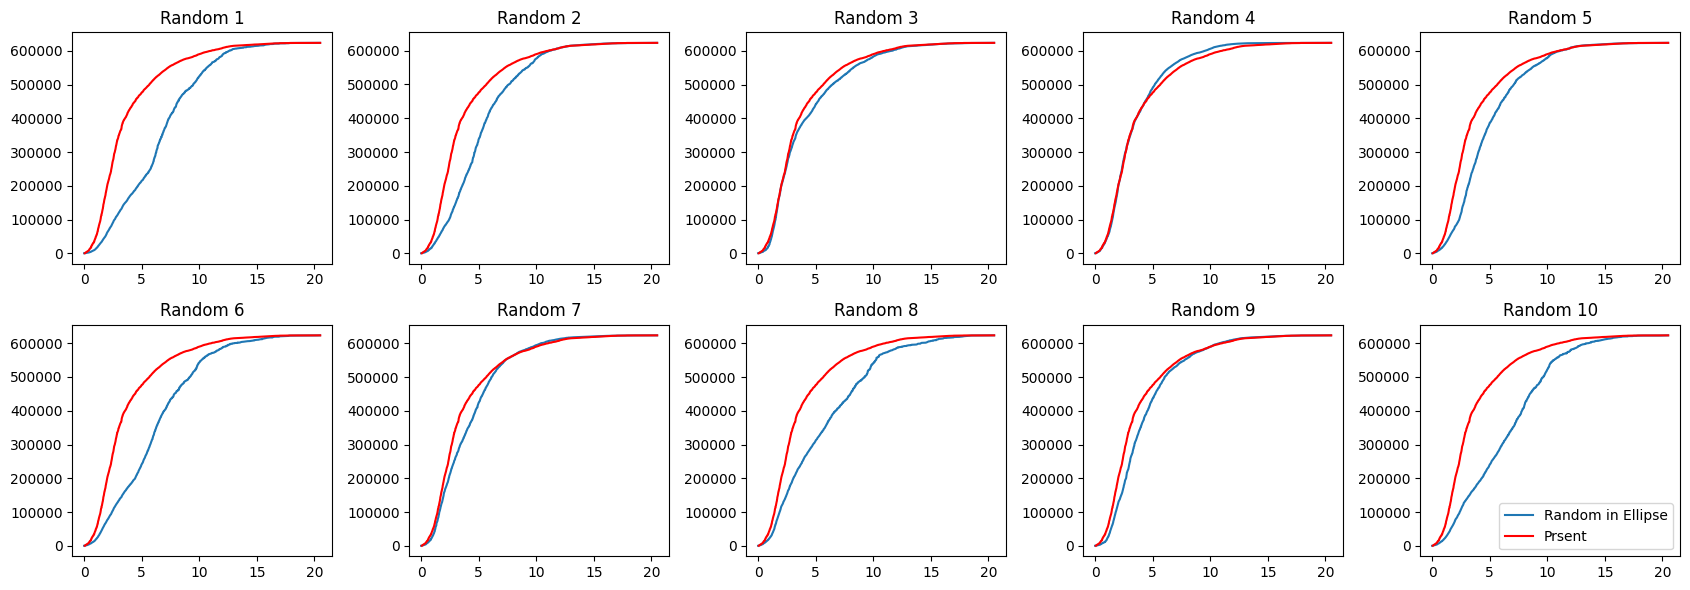

4214 [0.0, 0.05358281992992601, 0.05572713394703723, 0.057675469557528704, 0.06067167871664851, 0.06497805724952183, 0.0843764195791417, 0.0850409937965719, 0.10041258823944851, 0.10401844353202479, 0.10500422382127927, 0.1217300877644879, 0.12746311274287353, 0.1448500458575287, 0.14533125241350542, 0.17531371594703724, 0.17680325517451284, 0.18471438869576437, 0.19213003657914168, 0.2032682401239915, 0.21928272771664853, 0.22606989507451283, 0.22611216447926225, 0.2282083885575287, 0.22883564023944852, 0.24536678024952183, 0.2594943296575287, 0.263683760929926, 0.268115260929926, 0.2685550317644879, 0.2747272818575287, 0.2811750572394485, 0.29442863274287356, 0.2947052355791417, 0.3174195295320248, 0.32751192892992603, 0.33728654707451283, 0.35655229041350545, 0.36063236424952183, 0.37179146755752873, 0.37389319494738227, 0.3868476172394485, 0.3919446628575287, 0.3970326237644879, 0.40670544871664854, 0.4070017696575287, 0.4102363808212793, 0.4107217706575287, 0.4121806737166485, 0.4

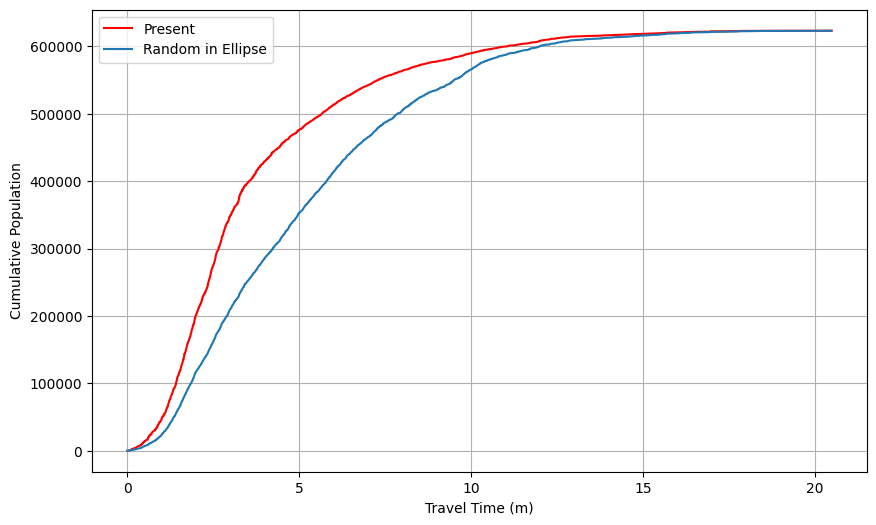

In [62]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
realNodes = [i for i in range(26)]
area = serviceArea(G, realNodes, 40)
print(len(area))
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
merged_df = pd.merge(result_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
grouped_data = merged_df.groupby('Distance')['average population'].sum()
cumulative_population = grouped_data.cumsum()

# ------- 여기는 랜덤판
result_x = []
result_y = []
iter = 0
fig = plt.figure(figsize=(17, 6)) # subplot drawing
for pointsList in randomPoints:
    iter +=1
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    area = serviceArea(G, random_nodes, 40)
    print(len(area))
    random_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
    random_counts = [random_df[random_df['Distance'] <= distance].shape[0] for distance in distances]
    mergedRandom = pd.merge(random_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
    groupedRandom = mergedRandom.groupby('Distance')['average population'].sum()
    randomPopulation = groupedRandom.cumsum()
    
    x = distances
    if len(x) > len(result_x):
        result_x = x
    if len(result_x) > len(cumulative_population.index):
        result_x = result_x[:len(cumulative_population.index)]
    y = randomPopulation.values.tolist()
    print(len(y), y[-1])
    if len(y) > len(cumulative_population.values):
        y = y[:len(cumulative_population.values)]
    if result_y == []:
        result_y = y
    else:
        for i in range(len(y)):
            result_y[i] = result_y[i] + y[i]
    # subplot
    x = x[:len(y)]
    ax = fig.add_subplot(2, 5, iter)
    ax.plot(x, y, label = 'Random in Ellipse')
    ax.plot(cumulative_population.index, cumulative_population.values, color = 'red', label = 'Prsent')
    ax.set_title(f"Random {iter}")
plt.tight_layout()
plt.legend()
plt.savefig('result/Random Ellipse_Population by Distance.png')
plt.show()

result_y = [y/10 for y in result_y]
print(len(result_x), result_x)
print(len(result_y), result_y)


distances = sorted(result_df['Distance'].unique())
cumulative_counts = [result_df[result_df['Distance'] <= distance].shape[0] for distance in distances]

plt.figure(figsize=(10, 6))
plt.plot(cumulative_population.index, cumulative_population.values, marker='o', markersize = 0, color = 'red', label = 'Present')
plt.plot(result_x, result_y, marker='o', markersize = 0, label = 'Random in Ellipse')
plt.legend()
plt.xlabel('Travel Time (m)')
plt.ylabel('Cumulative Population')
plt.grid(True)
plt.savefig('result/Ellipse_Population by Travel Time.png')
plt.show()

인구수*출동시간

In [15]:
def count119(graph, list119):
    retCount = {}
    ret = {}
    for node in list119:
        shortest_paths = nx.single_source_dijkstra_path_length(graph, node, cutoff=5, weight='weight')
        for key, value in shortest_paths.items():
            if key not in ret:
                ret[key] = value
                retCount[key] = 1
            elif value<ret[key]:
                ret[key] = value
                retCount[key] +=1
            else:
                retCount[key] += 1
    return retCount

In [16]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
carlist = [i for i in range(26)]
area = serviceArea(G, carlist, 40)
print(len(area))
result_df = pd.DataFrame(list(area.items()), columns=['ID', 'Distance'])
merged_df = pd.merge(result_df, nodes[['Id', 'average population']], left_on='ID', right_on='Id')
grouped_data = merged_df.groupby('Distance')['average population'].sum()
cumulative_population = grouped_data.cumsum()
totalSum = 0
for idx, node in nodes.iterrows():
    totalSum += node['average population']
print(f"Total population in Jeju: {totalSum}")

count = count119(G, carlist)
totalSum = 0
for carNum in carlist:
    area = serviceArea(G, [carNum], w=5)
    sum = 0
    for key, val in area.items():
        if key >1000:
            tmp = nodes.loc[nodes['Id'] == key, 'average population'].values[0]
            sum += tmp/count[key]
    print(f"car{carNum} people: {sum}")
    totalSum+=sum
print(f"Total Sum: {totalSum}")

4240
Total population in Jeju: 624051.0279870025
car0 people: 4745.449445
car1 people: 7142.015082000001
car2 people: 49369.713751516625
car3 people: 13851.94761533336
car4 people: 9768.294656999999
car5 people: 2588.42697
car6 people: 25274.05027796665
car7 people: 7423.840942000001
car8 people: 30451.99730903333
car9 people: 15610.752476000005
car10 people: 7423.173680000009
car11 people: 7714.513183999995
car12 people: 33396.52760443333
car13 people: 4114.736445000003
car14 people: 41355.849156949975
car15 people: 16431.334076666655
car16 people: 66591.04247508326
car17 people: 6539.673892500004
car18 people: 13102.14499733337
car19 people: 4865.221053999998
car20 people: 4123.814433000002
car21 people: 1232.8453620000007
car22 people: 32940.19538010002
car23 people: 13851.94761533336
car24 people: 46768.52188275005
car25 people: 9493.291222250016
Total Sum: 476171.3209872501


Total population in Jeju: 624051.0279870025
Total Sum: 476171.3209872501


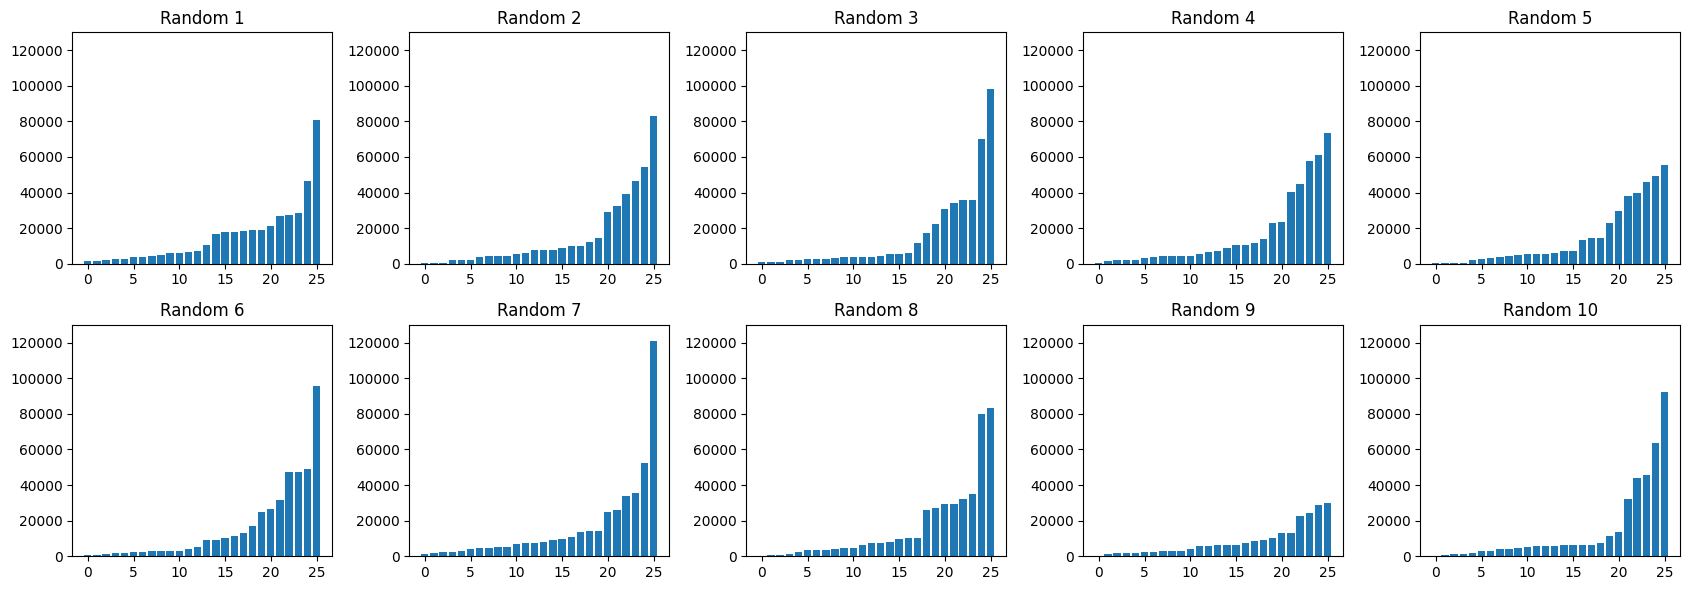

[629.8172241333334, 1019.2678165666666, 1368.4840782166666, 1842.7106221833333, 2218.6934666333336, 2937.9782976, 3447.8615328500005, 3766.3509581333333, 4020.2956932499997, 4432.853251297502, 4920.701134680954, 5609.147960350003, 6232.886084008336, 7202.253334630006, 8510.606053741672, 9265.219670027624, 10462.489748495958, 11827.701223750966, 15050.62887944419, 19008.2377766693, 24219.052522389266, 30354.32305682833, 36644.008652725955, 40172.64376050666, 55531.12664304499, 81297.93731719156]
[1232.8453620000007, 2588.42697, 4114.736445000003, 4123.814433000002, 4745.449445, 4865.221053999998, 6539.673892500004, 7142.015082000001, 7423.173680000009, 7423.840942000001, 7714.513183999995, 9493.291222250016, 9768.294656999999, 13102.14499733337, 13851.94761533336, 13851.94761533336, 15610.752476000005, 16431.334076666655, 25274.05027796665, 30451.99730903333, 32940.19538010002, 33396.52760443333, 41355.849156949975, 46768.52188275005, 49369.713751516625, 66591.04247508326]


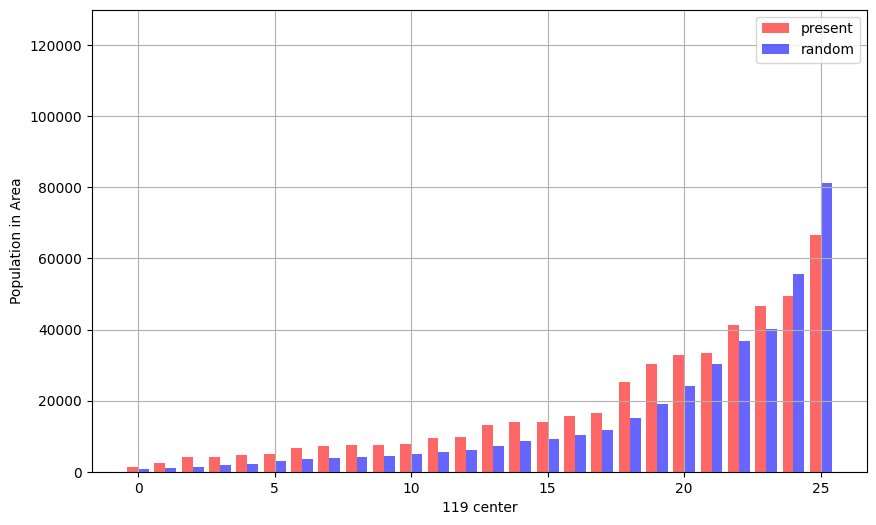

In [17]:
# ----- 여기는 현실판
G = nx.Graph()
for idx,row in nodes.iterrows():
    # add node to Graph G
    G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
for idx,row in jeju_links.iterrows():
    # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
    G.add_edge(row['Source'],row['Target'],weight = row['시간'])
G = connectRes(G, car)
carlist = [i for i in range(26)]
totalSum = 0
for idx, node in nodes.iterrows():
    totalSum += node['average population']
print(f"Total population in Jeju: {totalSum}")

random_Gnodes=[]
randG = list(G.nodes(data=True))
import random
for _ in range(10):
    tmp = []
    for _ in range(26):
        randNum = random.randint(0, len(randG))
        tmp.append((randG[randNum][1]['longitude'], randG[randNum][1]['latitude']))
    random_Gnodes.append(tmp)

count = count119(G, carlist)
totalSum = 0
serviceGraph = {}
for carNum in carlist:
    area = serviceArea(G, [carNum], w=5)
    sum = 0
    for key, val in area.items():
        if key >1000:
            tmp = nodes.loc[nodes['Id'] == key, 'average population'].values[0]
            sum += tmp/count[key]
    # print(f"car{carNum} people: {sum}")
    serviceGraph[carNum] = sum
    totalSum+=sum
print(f"Total Sum: {totalSum}")

# ------- 여기는 랜덤판
result_x = []
result_y = []
iter = 0
fig = plt.figure(figsize=(17, 6)) # subplot drawing
for pointsList in random_Gnodes:
    iter +=1
    G = nx.Graph()
    for idx,row in nodes.iterrows():
        # add node to Graph G
        G.add_node(row['Id'],Label=row['NODE_NAME'],latitude=row['latitude'], longitude=row['longitude'])
    for idx,row in jeju_links.iterrows():
        # Link attribute : 'Source', 'Target' and weight = '시간 between two nodes'
        G.add_edge(row['Source'],row['Target'],weight = row['시간'])    
    # make a dictionary for node position
    columns = ['longitude','latitude']
    df = pd.DataFrame(pointsList, columns=columns)
    G = connectRes(G, df)
    random_nodes = [i for i in range(26)]
    
    totalSum = 0
    for idx, node in nodes.iterrows():
        totalSum += node['average population']
    count = count119(G, random_nodes)
    totalSum = 0
    random_serviceGraph = {}
    for carNum in random_nodes:
        area = serviceArea(G, [carNum], w=5)
        sum = 0
        for key, val in area.items():
            if key >1000:
                tmp = nodes.loc[nodes['Id'] == key, 'average population'].values[0]
                sum += tmp/count[key]
        random_serviceGraph[carNum] = sum
        totalSum+=sum

    # subplot
    y = sorted(random_serviceGraph.values())
    ax = fig.add_subplot(2, 5, iter)
    ax.bar(random_nodes, y)
    if result_y == []:
        result_y = y
    else:
        for i in range(len(result_y)):
            result_y[i] = result_y[i] + y[i]
    ax.set_ylim(0, 130000)
    ax.set_title(f"Random {iter}")
result_y = [y/10 for y in result_y]

plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
present_y = sorted(serviceGraph.values())
print(result_y)
print(present_y)
plt.bar([pos - 0.2 for pos in carlist], present_y, color = 'red', width = 0.4, label = 'present', alpha = 0.6)
plt.bar([pos + 0.2 for pos in carlist], result_y, color = 'blue', width = 0.4, label = 'random', alpha = 0.6) 
plt.legend()
plt.ylim(0,130000)
plt.xlabel('119 center')
plt.ylabel('Population in Area')
plt.grid(True)
plt.savefig('result/Population by 119 center.png')
plt.show()

In [18]:
type(randomPoints[0][0])

tuple

In [65]:
import folium
std_point = (33.37283976160554, 126.4439861097205)
 
map_osm = folium.Map(location=std_point, zoom_start=10)

for x,y in random_Gnodes[0]:
    
  # 위도, 경도 튜플
    folium.Circle(
        location=(y,x),
        radius=1000,
        color='blue',
        weight=1,
        fill_opacity=0.6,
        opacity=1,
        fill_color='black',
        fill=True,  # gets overridden by fill_color
    ).add_to(map_osm)

map_osm.save('map 1000.html')
map_osm